# GNOD

Business goal:
Check the case_study_gnod.md file.

Make sure you've understood the big picture of your project:

the goal of the company (Gnod),
their current product (Gnoosic),
their strategy, and
how your project fits into this context.
Re-read the business case and the e-mail from the CTO, take a look at the flowchart and create an initial Trello board with the tasks you think you'll have to accomplish.

# GNOD | Part 4

## Lab | Unsupervised learning intro

Instructions  
It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

Check whether or not the song is in the Billboard Hot 200.
Collect the audio features from the Spotify API.
After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.

#### Importing libraries

In [71]:
# Standard Libraries
import numpy as np
import pandas as pd

#for plots
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#for clustering
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
import pickle
from sklearn.metrics import silhouette_score

#scaling numerical variables
from sklearn.preprocessing import StandardScaler

In [57]:
data = pd.read_csv('data_songs.csv')
data.head()

,title,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,It's Beginning to Look a Lot Like Christmas (w...,Perry Como,0.724,0.276,7.0,-12.250,1.0,0.0599,0.760,0.000000,0.1160,0.718,112.874,audio_features,2pXpURmn6zC5ZYDMms6fwa,spotify:track:2pXpURmn6zC5ZYDMms6fwa,https://api.spotify.com/v1/tracks/2pXpURmn6zC5...,https://api.spotify.com/v1/audio-analysis/2pXp...,155933.0,4.0
1,And I Love You So,Perry Como,0.415,0.220,8.0,-17.470,1.0,0.0261,0.878,0.651000,0.1250,0.268,90.267,audio_features,1naVD19eofGpFf6wosmHIe,spotify:track:1naVD19eofGpFf6wosmHIe,https://api.spotify.com/v1/tracks/1naVD19eofGp...,https://api.spotify.com/v1/audio-analysis/1naV...,197627.0,4.0
2,Christmas Dream,Perry Como,0.514,0.287,10.0,-13.971,1.0,0.0352,0.672,0.000004,0.0677,0.834,184.356,audio_features,1PrhnQxWAVYikCHcieRQiy,spotify:track:1PrhnQxWAVYikCHcieRQiy,https://api.spotify.com/v1/tracks/1PrhnQxWAVYi...,https://api.spotify.com/v1/audio-analysis/1Prh...,169160.0,4.0
3,(There's No Place Like) Home for the Holidays ...,Perry Como,0.532,0.401,5.0,-10.629,1.0,0.0525,0.869,0.000000,0.2220,0.450,143.823,audio_features,2GapxG7BxK55ihQRAlR39e,spotify:track:2GapxG7BxK55ihQRAlR39e,https://api.spotify.com/v1/tracks/2GapxG7BxK55...,https://api.spotify.com/v1/audio-analysis/2Gap...,178293.0,4.0
4,Magic Moments,Perry Como,0.719,0.257,0.0,-14.446,0.0,0.0435,0.880,0.000003,0.2570,0.750,103.829,audio_features,7bflxIMDz5mFxhQyYx1CEh,spotify:track:7bflxIMDz5mFxhQyYx1CEh,https://api.spotify.com/v1/tracks/7bflxIMDz5mF...,https://api.spotify.com/v1/audio-analysis/7bfl...,159907.0,4.0


In [58]:
#Checking for NaNs
data.isna().sum()

title               0
artist              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

In [59]:
#Checking for NaNs
data[data['danceability'].isna()==True]

,title,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature


In [60]:
# strategy: drop rows that have null values (only if there are very few)
data = data[data['danceability'].isna()==False]

In [61]:
#replace .csv file
data.to_csv('data_songs.csv', index = False)

#### Prepare Datatable for clustering:

In [62]:
data_cluster = data.drop(columns=['title','artist','type','id','uri','track_href','analysis_url'], axis=1)

In [63]:
display(data_cluster.shape)
data_cluster.head()

(7587, 13)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.724,0.276,7.0,-12.250,1.0,0.0599,0.760,0.000000,0.1160,0.718,112.874,155933.0,4.0
1,0.415,0.220,8.0,-17.470,1.0,0.0261,0.878,0.651000,0.1250,0.268,90.267,197627.0,4.0
2,0.514,0.287,10.0,-13.971,1.0,0.0352,0.672,0.000004,0.0677,0.834,184.356,169160.0,4.0
3,0.532,0.401,5.0,-10.629,1.0,0.0525,0.869,0.000000,0.2220,0.450,143.823,178293.0,4.0
4,0.719,0.257,0.0,-14.446,0.0,0.0435,0.880,0.000003,0.2570,0.750,103.829,159907.0,4.0


#### Scaling the data

In [64]:
scaler = StandardScaler().fit(data_cluster)
data_cluster_scaled = scaler.transform(data_cluster)

In [65]:
data_cluster_scaled = pd.DataFrame(data_cluster_scaled, columns = data_cluster.columns)
display(data_cluster_scaled.shape)
data_cluster_scaled.head()

(7587, 13)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.748028,-1.610081,0.490890,-1.006659,0.692477,-0.197674,1.618128,-0.299115,-0.450867,0.603879,-0.253011,-0.958492,0.206788
1,-1.186386,-1.869077,0.770562,-2.322013,0.692477,-0.616250,2.016243,3.386613,-0.391008,-1.202132,-1.061285,-0.391765,0.206788
2,-0.566622,-1.559206,1.329905,-1.440323,0.692477,-0.503556,1.321229,-0.299090,-0.772112,1.069428,2.302704,-0.778704,0.206788
3,-0.453938,-1.031963,-0.068453,-0.598194,0.692477,-0.289315,1.985878,-0.299115,0.254142,-0.471701,0.853517,-0.654563,0.206788
4,0.716727,-1.697954,-1.466810,-1.560015,-1.444092,-0.400770,2.022990,-0.299100,0.486929,0.732306,-0.576399,-0.904476,0.206788


#### Pickle the scaler for future use

In [66]:
pickle.dump(scaler,open('scaler.p', 'wb'))

#### Save the scaled dataset ready for clustering

In [67]:
data_cluster_scaled.to_csv('playlist_scaled.csv', index = False)

### Clustering

#### Choosing k

In [69]:
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(data_cluster_scaled)
    inertia.append(kmeans.inertia_)


/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

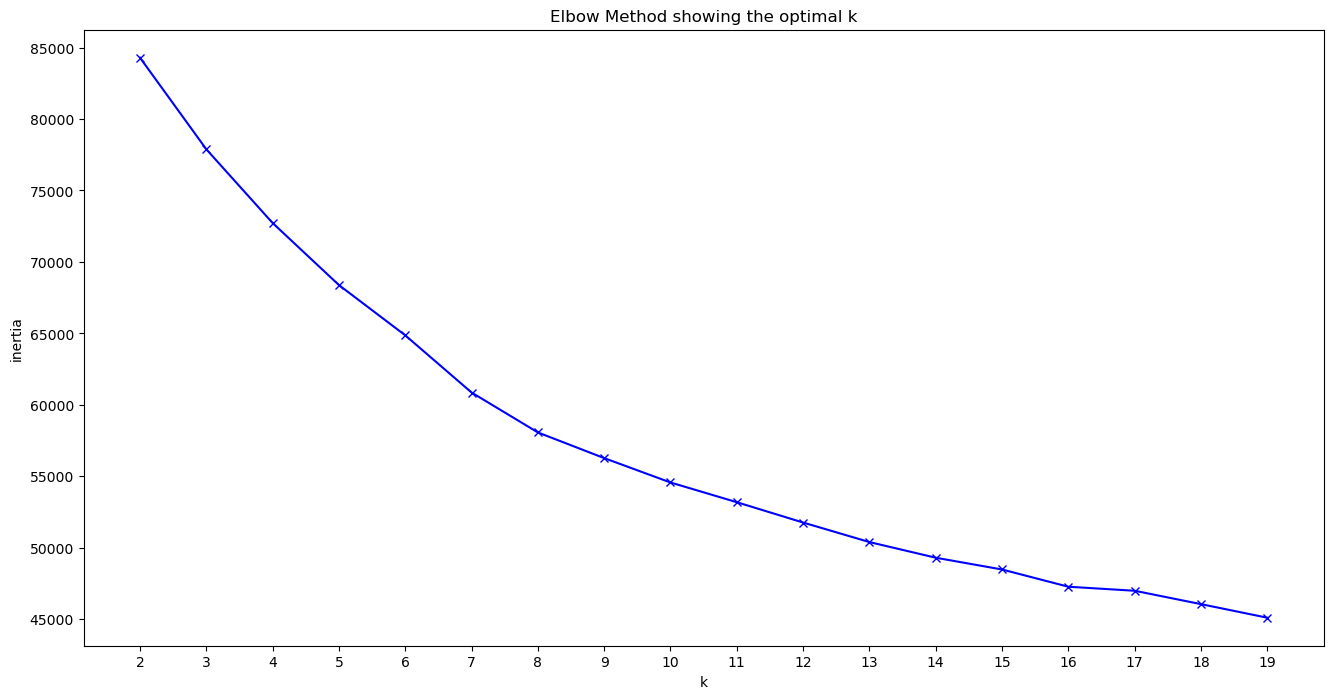

In [70]:
#%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

We cannot really see an "elbow" so we have to look for the silhouette score

#### Silhouette Score

/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

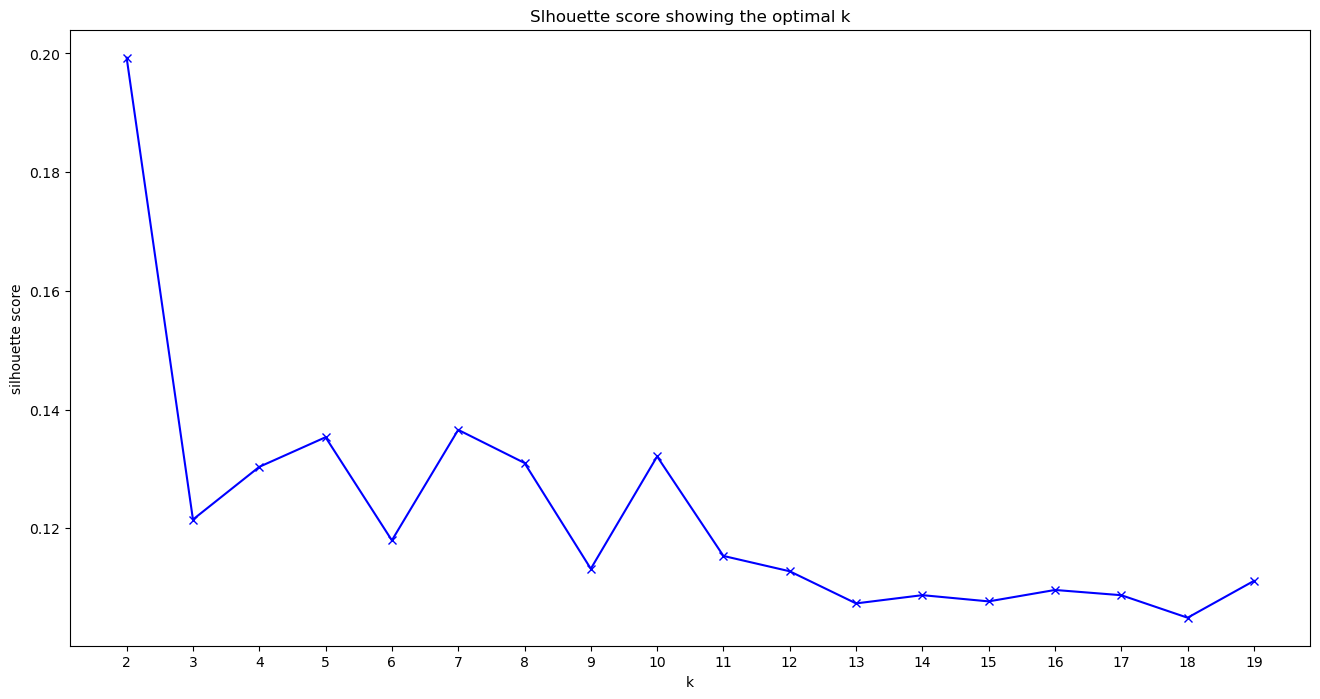

In [72]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(data_cluster_scaled)
    silhouette.append(silhouette_score(data_cluster_scaled, kmeans.predict(data_cluster_scaled)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

I will choose 7 clusters, since it is the highest point, when not considering the k=2 option.

#### Clustering

In [73]:
kmeans = cluster.KMeans(n_clusters=7, random_state = 1234)
kmeans.fit(data_cluster_scaled)

/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=7, random_state=1234)

In [75]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(data_cluster_scaled)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    1291
1    1629
2     628
3    2643
4     566
5     388
6     442
dtype: int64

In [78]:
#Inertia
kmeans.inertia_ 

60863.4706564707

##### Pickle kmeans for future use

In [79]:
pickle.dump(kmeans,open('kmeans_7_cluster.p', 'wb'))

### Save the clustering information in the dataframe

In [80]:
data_clustered = data_cluster_scaled.assign(clusters = clusters)
data_clustered.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,clusters
0,0.748028,-1.610081,0.490890,-1.006659,0.692477,-0.197674,1.618128,-0.299115,-0.450867,0.603879,-0.253011,-0.958492,0.206788,0
1,-1.186386,-1.869077,0.770562,-2.322013,0.692477,-0.616250,2.016243,3.386613,-0.391008,-1.202132,-1.061285,-0.391765,0.206788,5
2,-0.566622,-1.559206,1.329905,-1.440323,0.692477,-0.503556,1.321229,-0.299090,-0.772112,1.069428,2.302704,-0.778704,0.206788,0
3,-0.453938,-1.031963,-0.068453,-0.598194,0.692477,-0.289315,1.985878,-0.299115,0.254142,-0.471701,0.853517,-0.654563,0.206788,0
4,0.716727,-1.697954,-1.466810,-1.560015,-1.444092,-0.400770,2.022990,-0.299100,0.486929,0.732306,-0.576399,-0.904476,0.206788,0


In [81]:
data_clustered.to_csv('playlist_7_clusters.csv', index=False)